# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

In [107]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def calibrateCamera(path_to_calibration_images):
    """
    Calculates calibration parameters of a camera.
    """
    num_inside_corners_x = 9
    num_inside_corners_y = 6
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((num_inside_corners_x*num_inside_corners_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:num_inside_corners_x,0:num_inside_corners_y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    cal_images = glob.glob(path_to_calibration_images)
    
    # Step through the list and search for chessboard corners
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (num_inside_corners_x,num_inside_corners_y),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (num_inside_corners_x,num_inside_corners_y), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    ret, cam_matrix, dist_coeff, rot_vecs, trans_vecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cam_matrix, dist_coeff

## 2. Apply distortion correction to raw images

In [108]:
def undistortImage(image, camera_matrix, dist_coeff):
    """
    Undistorts a camera image using the camera calibration parameters.
    """
    undist = cv2.undistort(image, camera_matrix, dist_coeff, None)
    return undist

## 3. Create a thresholded binary image

In [3]:
def absSobelThreshold(image, orient='x', sobel_kernel=3, thresh=(0,255)):
    """
    Thresholds an image based on the Sobel x or Sobel y operator.
    
    Only keeps the pixels of the image within the threshold.
    The rest of the image is set to black.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    # Convert the absolute value image to 8 bit
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary threshold to select pixels based on gradient strength
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sobel_binary

In [4]:
def magnitudeThreshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Thresholds an image based on the magnitude of the Sobel operator.
    
    Only keeps the pixels of the image within the threshold.
    The rest of the image is set to black.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255*magnitude/np.max(magnitude))
    # Create a binary mask where mag thresholds are met
    magnitude_binary = np.zeros_like(scaled_mag)
    magnitude_binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    
    return magnitude_binary

In [5]:
def directionThreshold(image, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    Thresholds an image based on the direction of the Sobel operator.
    
    Only keeps the pixels of the image within the threshold.
    The rest of the image is set to black.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Create a binary mask where direction thresholds are met
    direction_binary = np.zeros_like(grad_dir)
    direction_binary[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    
    return direction_binary

In [6]:
def hlsSColorThreshold(image, thresh=(0, 255)):
    """
    Thresholds an image based on saturation values of the HLS color space.
    
    Only keeps the pixels of the image within the threshold.
    The rest of the image is set to black.
    """
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1

    return s_binary

In [7]:
def regionOfInterest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## 4. Apply a perspective transform to rectify the binary image

In [9]:
def warpImage(undistorted_img, M):
    """
    Applies a perspective transform to an image.
    """
    warped = cv2.warpPerspective(undistorted_img, M, (undistorted_img.shape[1],undistorted_img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

## 5. Detect lane pixels and find the lane boundary

In [115]:
def windowMask(width, height, img_ref, center,level):
    """
    Creates a window mask.
    """
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def findWindowCentroids(image, window_width, window_height, margin):
    """
    Finds window centroids of maximum convolution signal between a window mask and an image.
    """
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        # If no centroid is found, use the previous one.
        if (np.sum(conv_signal[l_min_index:l_max_index]) != 0):
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
         # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if (np.sum(conv_signal[r_min_index:r_max_index]) != 0):
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    slidingWindowViz(image, window_centroids, window_width, window_height)

    return window_centroids

def slidingWindowViz(binary_warped_image, window_centroids, window_width, window_height):
    """
    Visualizes window centroids on top of the input image.
    """
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped_image)
        r_points = np.zeros_like(binary_warped_image)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # windowMask is a function to draw window areas
            l_mask = windowMask(window_width,window_height,binary_warped_image,window_centroids[level][0],level)
            r_mask = windowMask(window_width,window_height,binary_warped_image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped_image, binary_warped_image, binary_warped_image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0, dtype=cv2.CV_8UC1) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warped_image,binary_warped_image,binary_warped_image)),np.uint8)

    # Display the final results
    plt.figure()
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
def detectLanesFirstImage(binary_warped_image, left_line, right_line):
    """
    Detects lane pixels and fits a polynomial to them in the first image of a sequence.
    
    Does not use any prior knowledge of previous lane pixel positions.
    """
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = findWindowCentroids(binary_warped_image, window_width, window_height, margin)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for level in range(0, len(window_centroids)):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_image.shape[0] - (level+1)*window_height
        win_y_high = binary_warped_image.shape[0] - level*window_height
        win_xleft_low = window_centroids[level][0] - window_width
        win_xleft_high = window_centroids[level][0] + window_width
        win_xright_low = window_centroids[level][1] - window_width
        win_xright_high = window_centroids[level][1] + window_width
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_line.current_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    right_line.current_fit = np.polyfit(right_line.ally, right_line.allx, 2)
    
    # FOR VISUALIZATION:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_image.shape[0]-1, binary_warped_image.shape[0] )
    left_line.recent_xfitted = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_line.recent_xfitted = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]

    out_img = binary_warped_image
    
    plt.figure()
    plt.imshow(out_img, cmap='gray')
    plt.plot(left_line.recent_xfitted, ploty, color='yellow')
    plt.plot(right_line.recent_xfitted, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

def detectLanesAfterFirstImage(binary_warped_image, curr_left_line, curr_right_line, left_line, right_line):
    """
    Detects lane pixels and fits a polynomial to them for images that 
    come after the first image in a sequence.
    
    Uses prior knowledge of previous lane pixel positions.
    """
    nonzero = binary_warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + 
    left_line.best_fit[2] - margin)) & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + 
    left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin))).nonzero()[0] 

    right_lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + 
    right_line.best_fit[2] - margin)) & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + 
    right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin))).nonzero()[0] 
    
    # Again, extract left and right line pixel positions
    curr_left_line.allx = nonzerox[left_lane_inds]
    curr_left_line.ally = nonzeroy[left_lane_inds] 
    curr_right_line.allx = nonzerox[right_lane_inds]
    curr_right_line.ally = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    curr_left_line.current_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    curr_right_line.current_fit = np.polyfit(right_line.ally, right_line.allx, 2)
    
    # FOR VISUALIZATION:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_image.shape[0]-1, binary_warped_image.shape[0] )
    curr_left_line.recent_xfitted = curr_left_line.current_fit[0]*ploty**2 + curr_left_line.current_fit[1]*ploty + curr_left_line.current_fit[2]
    curr_right_line.recent_xfitted = curr_right_line.current_fit[0]*ploty**2 + curr_right_line.current_fit[1]*ploty + curr_right_line.current_fit[2] 
    
    out_img = binary_warped_image

    plt.figure()
    plt.imshow(out_img, cmap='gray')
    plt.plot(left_line.recent_xfitted, ploty, color='yellow')
    plt.plot(right_line.recent_xfitted, ploty, color='yellow')

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def getCurvature(left_line, right_line, y_val):
    """
    Finds the curvature (in meters) of lane boundaries.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_val*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_val*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

def getOffsetFromCenter(left_line, right_line, img_width):
    """
    Finds the offset of the car from the center of the lane (in meters).
    """
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    pixels_from_center = (right_line.allx[0] - left_line.allx[0]) / 2 + left_line.allx[0] - img_width / 2
    left_line.offset_from_center = xm_per_pix * pixels_from_center
    right_line.offset_from_center = xm_per_pix * pixels_from_center

## 7. Warp detected lane boundaries back onto the original image.

In [12]:
def warpLaneBoundariesOntoImage(img, left_line, right_line, ploty, M_inverse):
    """
    Performs an inverse perspective transform on lane boundaries and 
    displays the lane on top of the original image.
    """
    # Create an image to draw the lines on
    lane_img = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(lane_img, M_inverse, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [np.array([False])]
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.offset_from_center = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [116]:
def linesInsane(left_line, right_line):
    """
    Checks left and right lane boundaries for strange results.
    """
    curvature_difference_threshold = 1000 # m
    width_threshold = 700 # pixels
    fit_coeff_threshold_a = 0.0006
    fit_coeff_threshold_b = 1
    if (np.absolute(left_line.radius_of_curvature - right_line.radius_of_curvature) > curvature_difference_threshold 
        or right_line.allx[0] < left_line.allx[0] or right_line.allx[0] - left_line.allx[0] > width_threshold or
        np.absolute(left_line.current_fit[0] - right_line.current_fit[0]) > fit_coeff_threshold_a or
        np.absolute(left_line.current_fit[1] - right_line.current_fit[1]) > fit_coeff_threshold_b):
            return True
    return False

## Pipeline

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

In [16]:
#1 Calibrate camera
cam_matrix, dist_coeff = calibrateCamera('camera_cal/*.jpg')
#2 Get perspective transform
src = np.float32([[610,450], [725,450], [1125,710], [285,710]])
dst = np.float32([[325,0],[950,0],[950,710],[325,710]])
M = cv2.getPerspectiveTransform(src, dst)
M_inverse = cv2.getPerspectiveTransform(dst, src)

1


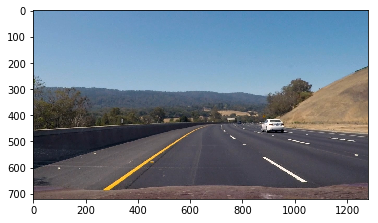

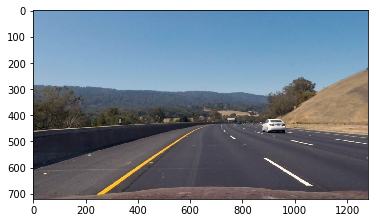

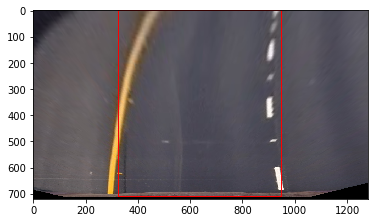

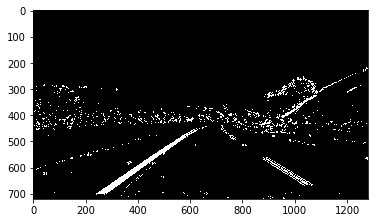

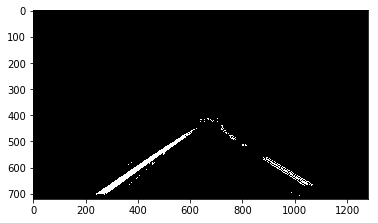

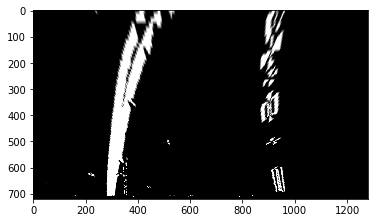

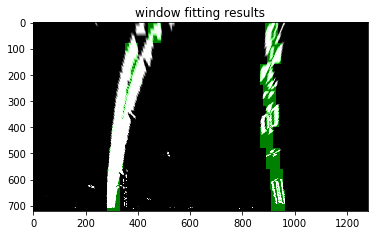

508.062923496
599.807667346
-0.222


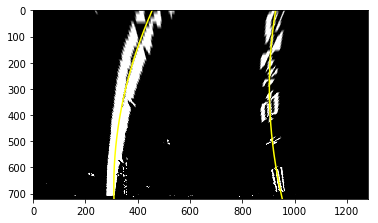

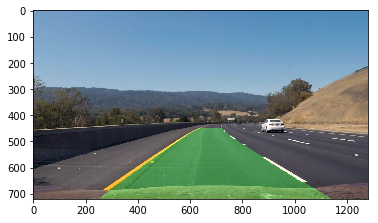

In [131]:
#3 Loop through images
project_video = VideoFileClip("project_video.mp4")
first_image = True
test_images = glob.glob('test_images/test3.jpg')

left_line = Line()
right_line = Line()
reset_counter = 0
images_list = []
counter = 0
#for img in project_video.iter_frames():
for img_file in test_images:
    counter = counter + 1
    print(counter)

    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img)
    # Undistort raw images
    undistorted_img = undistortImage(img, cam_matrix, dist_coeff)
    plt.figure()
    plt.imshow(undistorted_img)
    
    # Create an image to draw the lines on
#     src = np.int32([[610,450], [725,450], [1125,710], [285,710]])
#     dst = np.int32([[325,0],[950,0],[950,710],[325,710]])
#     src = src.reshape((-1,1,2))
#     dst = dst.reshape((-1,1,2))
#     src_img = img
#     cv2.polylines(src_img,[src],True,(255,0,0), 3)
#     plt.figure()
#     plt.imshow(src_img)
    
    warped_img_test = warpImage(img, M)
    #cv2.polylines(warped_img_test,[dst],True,(255,0,0), 3)
    plt.figure()
    plt.imshow(warped_img_test)
    # Apply thresholds
    gaussian_img = gaussian_blur(undistorted_img, 3)
    gradx = absSobelThreshold(gaussian_img, orient='x', sobel_kernel=15, thresh=(40,90))
    grady = absSobelThreshold(gaussian_img, orient='y', sobel_kernel=15, thresh=(40,150))
    mag_binary = magnitudeThreshold(gaussian_img, sobel_kernel=15, mag_thresh=(20,150))
    dir_binary = directionThreshold(gaussian_img, sobel_kernel=15, dir_thresh=(0.4, 1.2))
    s_binary = hlsSColorThreshold(gaussian_img, thresh=(190, 255))
    combined_thresh = np.zeros_like(dir_binary)
    combined_thresh[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | s_binary == 1] = 1
    plt.figure()
    plt.imshow(combined_thresh, cmap='gray')
    vertices = np.array([[(150,img.shape[0]),(650,410),(700,410),(img.shape[1]-100,img.shape[0]), 
                          (1000,img.shape[0]),(650,430),(300, img.shape[0])]], dtype=np.int32)
    roi_img = regionOfInterest(combined_thresh, vertices)
    plt.figure()
    plt.imshow(roi_img, cmap='gray')
    
    # Warp image
    warped_img = warpImage(combined_thresh, M)
    plt.figure()
    plt.imshow(warped_img, cmap='gray')
    
    curr_left_line = Line()
    curr_right_line = Line()
    # Detect lane pixels
    if left_line.bestx is None:
        detectLanesFirstImage(warped_img, curr_left_line, curr_right_line)
    else:
        detectLanesAfterFirstImage(warped_img, curr_left_line, curr_right_line, left_line, right_line)
    
    # Get curvature and offset from center
    getCurvature(curr_left_line, curr_right_line, img.shape[0])
    getOffsetFromCenter(curr_left_line, curr_right_line, img.shape[1])
    print(curr_left_line.radius_of_curvature)
    print(curr_right_line.radius_of_curvature)
    print(curr_left_line.offset_from_center)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    if linesInsane(curr_left_line, curr_right_line):
        print("Lines failed sanity check")
        left_line.detected = False
        right_line.detected = False
        if left_line.bestx is not None:
            # Use the previous fit for this frame
            lanes_on_img = warpLaneBoundariesOntoImage(img, left_line, right_line, ploty, M_inverse)
            images_list.append(lanes_on_img)
        continue
        
    # Update the tracked left and right lines
    if first_image:
        curr_left_line.bestx = curr_left_line.recent_xfitted
        curr_right_line.bestx = curr_right_line.recent_xfitted
        curr_left_line.best_fit = curr_left_line.current_fit
        curr_right_line.best_fit = curr_right_line.current_fit
        first_image = False
    else:
        curr_left_line.bestx = np.divide(left_line.bestx + curr_left_line.recent_xfitted, 2)
        curr_right_line.bestx = np.divide(right_line.bestx + curr_right_line.recent_xfitted, 2)
        curr_left_line.best_fit = np.divide(left_line.best_fit + curr_left_line.current_fit, 2)
        curr_right_line.best_fit = np.divide(right_line.best_fit + curr_right_line.current_fit, 2)
        curr_left_line.diffs = curr_left_line.current_fit - left_line.current_fit
        curr_right_line.diffs = curr_right_line.current_fit - right_line.current_fit
        
    curr_left_line.detected = True
    curr_right_line.detected = True
    
    left_line = curr_left_line
    right_line = curr_right_line
    
    # Warp the detected lane boundaries back onto the original image
    lanes_on_img = warpLaneBoundariesOntoImage(img, left_line, right_line, ploty, M_inverse)
    plt.figure()
    plt.imshow(lanes_on_img)
    images_list.append(lanes_on_img)

#video_output = 'output_images/lane_video_final.mp4'
#lane_clip = ImageSequenceClip(images_list, project_video.fps)
#lane_clip.write_videofile(video_output, audio=False)